In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skbio import TreeNode
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-15.6.0-x86_64-i386-64bit
Python 3.5.3 |Continuum Analytics, Inc.| (default, Mar  6 2017, 12:15:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
NumPy 1.13.0
SciPy 0.19.0
Scikit-Learn 0.18.1


In [2]:
from src.sim import chain_interactions
gradient = np.linspace(0, 50, 100)

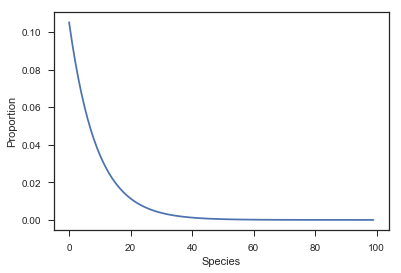

In [3]:
from scipy.stats import expon
from skbio.stats.composition import closure

x = np.linspace(0, 11, 100)
contaminant_urn = closure(expon.pdf(x))
plt.plot(contaminant_urn)
plt.xlabel('Species')
plt.ylabel('Proportion')

In [4]:
contaminant_urns = np.repeat(np.expand_dims(contaminant_urn, axis=0),
                             len(gradient), axis=0)
microbial_table = closure(contaminant_urns)

In [5]:
from skbio.stats.composition import closure
from src.sim import compositional_noise
from numpy.random import RandomState
from skbio.stats.composition import perturb

# force closure to 1
microbial_table = closure(microbial_table)
rng = RandomState(0)
cov = np.eye(microbial_table.shape[1]-1)

# add compositional nose
m_noise = compositional_noise(cov, nsamp=len(gradient), rng=rng)
microbial_table = np.vstack([
    perturb(microbial_table[i, :], m_noise[i, :])
    for i in range(len(gradient))])

In [6]:
from src.sim import multinomial_sample
microbial_table = multinomial_sample(microbial_table, lam=10000)

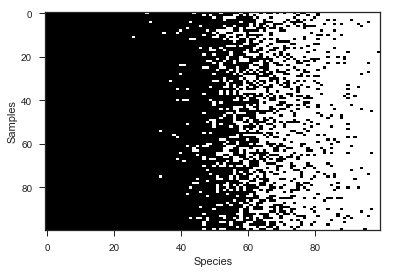

In [7]:
plt.imshow(microbial_table>0, aspect='auto', interpolation='nearest')
plt.xlabel('Species')
plt.ylabel('Samples')

In [8]:
sample_ids = ["S%d" % i for i in range(microbial_table.shape[0])]
microbial_table = pd.DataFrame(microbial_table, index=sample_ids)
intercept = np.array([0] * len(gradient))
group = np.array([0]*(len(gradient)//2) + [1]*(len(gradient)//2))
rd = np.random.randint(0, 2, size=len(gradient))
metadata = pd.DataFrame({'Intercept': intercept,
                         'Group': rd,
                         'Gradient': gradient}, index=sample_ids)

In [9]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement

ctable = pd.DataFrame(microbial_table+1,
                      index=microbial_table.index, 
                      columns=microbial_table.columns)
ctable = pd.DataFrame(clr(centralize(microbial_table+1)),
                      index=microbial_table.index, 
                      columns=microbial_table.columns)

rfc = PLSRegression(n_components=2)
rfc.fit(X=ctable.values, Y=metadata.Group)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

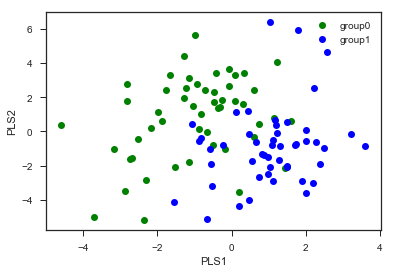

In [10]:
midx = metadata.Group==0
lidx = metadata.Group==1
plt.plot(rfc.x_scores_[midx, 0], rfc.x_scores_[midx, 1], 'og', label='group0')
plt.plot(rfc.x_scores_[lidx, 0], rfc.x_scores_[lidx, 1], 'ob', label='group1')
plt.xlabel('PLS1')
plt.ylabel('PLS2')
plt.legend()